In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from math import pi, sin, cos, atan2, sqrt
import khepera3 as khep

c:\Python311\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


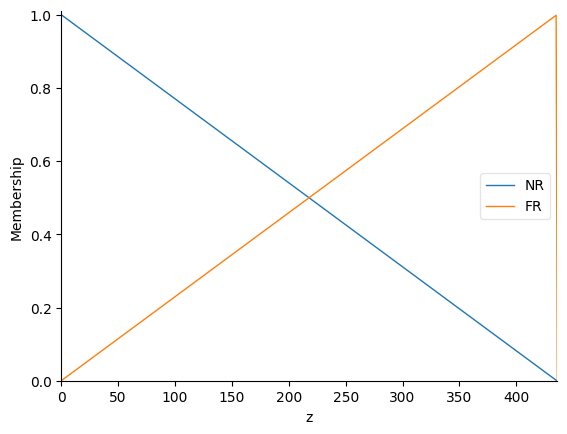

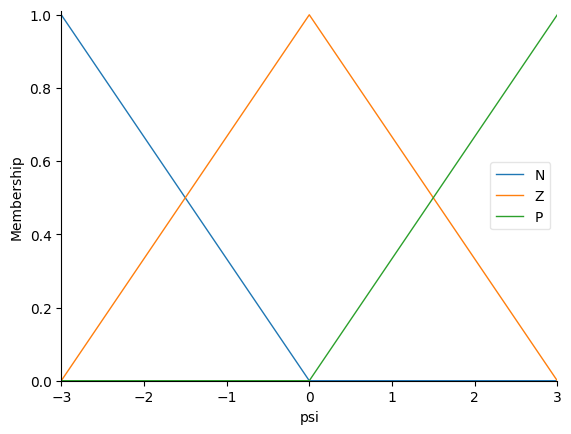

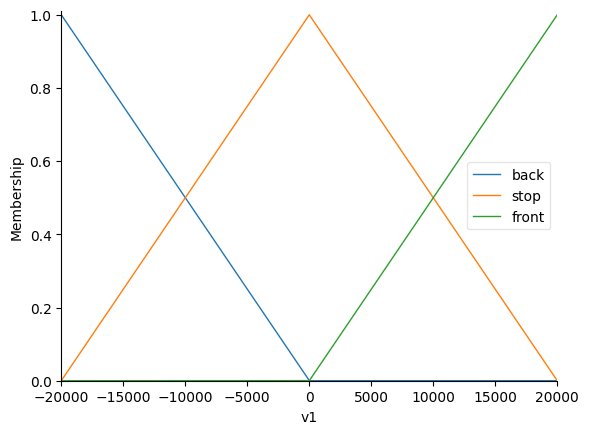

In [2]:
def k3FuzzyGoalDef():
    R           = 44 #[mm]
    MaxZ        = 7*R*np.sqrt(2)
    MaxSpeed    = 20000
    MaxPsi      = 3
    z           = ctrl.Antecedent(np.arange(0,MaxZ+1,1), 'z')
    psi         = ctrl.Antecedent(np.arange(-MaxPsi,MaxPsi+1,1), 'psi')
    vl          = ctrl.Consequent(np.arange(-MaxSpeed,MaxSpeed+1,1), 'v1')
    vr          = ctrl.Consequent(np.arange(-MaxSpeed,MaxSpeed+1,1), 'v2')
    
    z['NR']   = fuzz.trimf(z.universe, [0,    0, MaxZ])
    z['FR']   = fuzz.trimf(z.universe, [0,   MaxZ , MaxZ])
    
    psi['N']  = fuzz.trimf(psi.universe, [-MaxPsi,   -MaxPsi , 0])
    psi['Z']  = fuzz.trimf(psi.universe, [-MaxPsi,   0 , MaxPsi])
    psi['P']  = fuzz.trimf(psi.universe, [0,   MaxPsi , MaxPsi])
    
    vl['back']  = fuzz.trimf(vl.universe, [-MaxSpeed,   -MaxSpeed , 0])
    vl['stop']  = fuzz.trimf(vl.universe, [-MaxSpeed,   0 , MaxSpeed])
    vl['front'] = fuzz.trimf(vl.universe, [0,   MaxSpeed , MaxSpeed])    
    
    vr['back']  = fuzz.trimf(vr.universe, [-MaxSpeed,   -MaxSpeed , 0])
    vr['stop']  = fuzz.trimf(vr.universe, [-MaxSpeed,   0 , MaxSpeed])
    vr['front'] = fuzz.trimf(vr.universe, [0,   MaxSpeed , MaxSpeed])    
    
    z.view()
    psi.view()
    vl.view()
    
    # rules definition
    # Rule in a fuzzy control system, connecting antecedent(s) to consequent(s)
    rule1 = ctrl.Rule(antecedent=(z['NR'] & psi['N']), consequent=(vl['back'], vr['front']) )
    
    rule2 = ctrl.Rule(antecedent=(z['NR'] & psi['Z']), consequent=(vl['stop'], vr['stop']) )
            
    rule3 = ctrl.Rule(antecedent=(z['NR'] & psi['P']), consequent=(vl['front'], vr['back']) )
            
    rule4 = ctrl.Rule(antecedent=(z['FR'] & psi['N']), consequent=(vl['back'], vr['front']) )
            
    rule5 = ctrl.Rule(antecedent=(z['FR'] & psi['Z']), consequent=(vl['front'], vr['front']) )
            
    rule6 = ctrl.Rule(antecedent=(z['FR'] & psi['P']), consequent=(vl['front'], vr['back']) )
            
    
    # The system is initialized and populated with a set of fuzzy Rules
    goal_ctr = ctrl.ControlSystem([rule1,rule2,rule3,rule4,rule5,rule6])
    # Calculate results from a ControlSystem
    goal_sym = ctrl.ControlSystemSimulation(goal_ctr)
    return goal_sym
k3FuzzyGoalDef()

In [7]:
myPositon = [0,0]
def setPositon(x,y):
    myPositon[0] = x
    myPositon[1] = y

def readPositon():
    return myPositon

KeyboardInterrupt: 

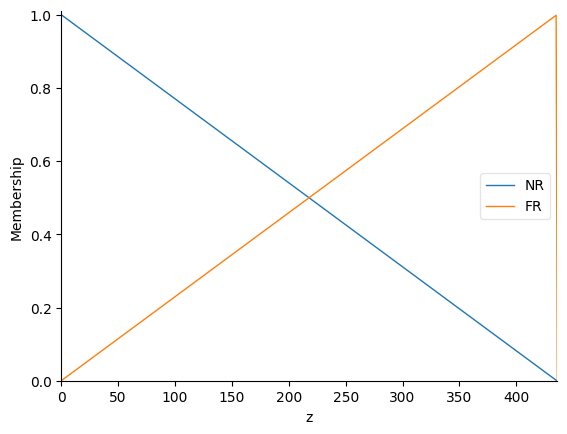

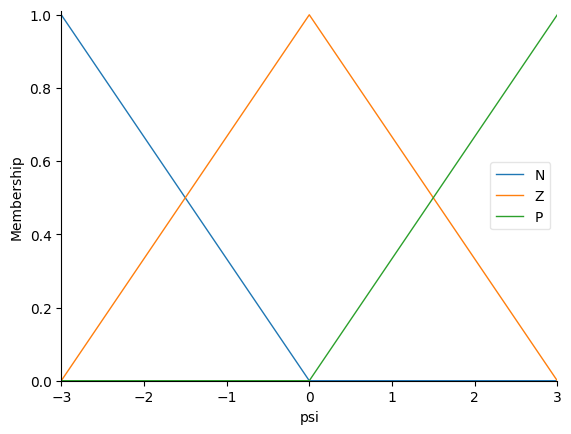

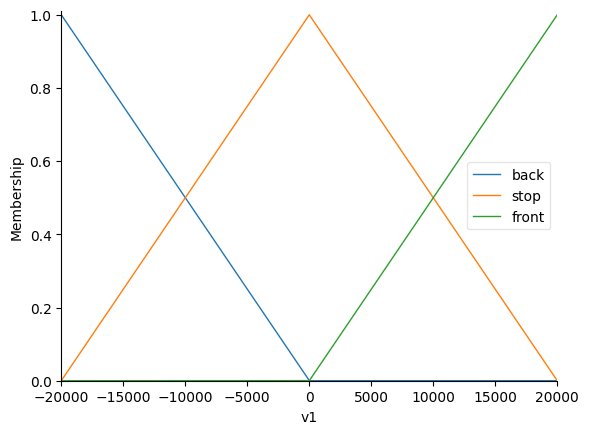

In [8]:


def k3FuzzyGoalEval(goal_sym,val_z,val_psi):
 # Compute the fuzzy system
 goal_sym.input['z'] = val_z
 goal_sym.input['psi'] = val_psi
 goal_sym.compute()
 # print('vl=',avoid_sym.output['vl'], ' vr=',avoid_sym.output['vr'])
 return goal_sym
def k3FuzzyGoalLoop(xg,yg):
 goal_sym = k3FuzzyGoalDef()
 # odometry
 DR=88.0
 MPP=0.047
 kat_theta=0
 angle = 0
 x=0
 y=0
 cl=0
 cr=0
 cl_old=10
 cr_old=10
 z=0
 psi=0

 setPositon(0,0) # Encoders resetting

 res = False
 while not res:
    c = readPositon() # Reading the state of the encoders
    cl = c[0]
    cr = c[1]
    if (cl_old != cl) | (cr_old != cr):
        dl = cl - cl_old
        dr = cr - cr_old
        cl_old = cl
        cr_old = cr
        if dl != dr:
            angle = (dr - dl)/DR*MPP
            radius = (DR/2)*(dl + dr)/(dr - dl)
            forward = radius*sin(angle)
            lateral = radius*(1.0 - cos(angle))
        else:
            angle = 0.0
            forward = dl*MPP
            lateral = 0.0
        dx = cos(kat_theta)
        dy = sin(kat_theta)
        x = x + forward*dx - lateral*dy
        y = y + forward*dy + lateral*dx
        kat_theta =(kat_theta+ angle)
        psi=kat_theta-(atan2((yg-y),(xg-x)))
        z=sqrt(pow((xg-x),2)+pow((yg-y),2))
        if psi >= pi:
            psi = psi - 2*pi
        if psi <= -pi:
            psi = psi + 2*pi
 goal_sym = k3FuzzyGoalEval(goal_sym, z, psi)
 khep.k3SetSpeed(s,goal_sym.output['vl'],goal_sym.output['vr'])
 print(f'z={z}, psi={psi*180/pi}')
 if z<60:
    setPositon(0,0) # Encoders resetting
    res = True
    
k3FuzzyGoalLoop(1000,1000)